# Fashion MNIST using PyTorch

## 1. Importing libraries

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer


# Custom
import mllib.DNN_utils as DNN_utils

import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

## 2. Getting dataset

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="../",  # where to download data to?
    train=True,  # get training data
    download=True,  # download data if it doesn't exist on disk
    transform=ToTensor(),  # images come as PIL format, we want to turn into Torch tensors
    target_transform=None,  # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="../", train=False, download=True, transform=ToTensor()  # get test data
)

### 2.1 Taking a peek at the data

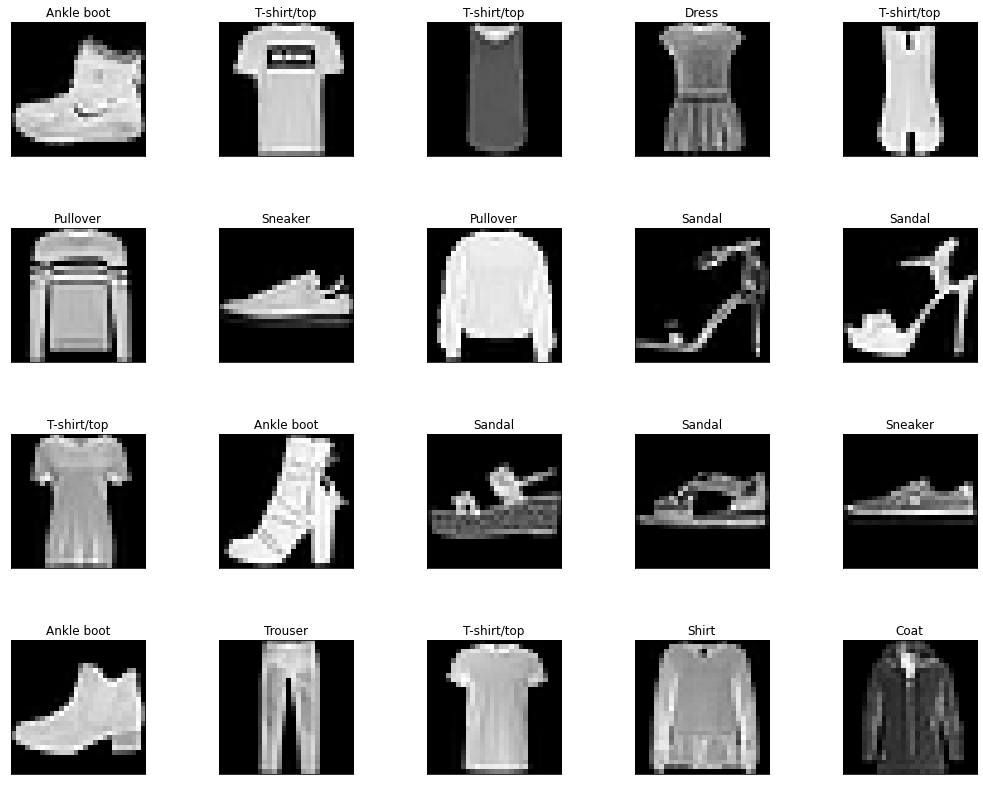

In [3]:
fig, ax = plt.subplots(4, 5, figsize=(15, 12))
fig.tight_layout(pad=4)
ax = ax.ravel()

for i in range(20):
    ax[i].imshow(train_data[i][0].view(28, 28), cmap="gray")
    ax[i].set_title("{}".format(train_data.classes[train_data[i][1]]))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

### 2.2 Loadig the data using DataLoader
- Helps load data into a model for training and inference.

In [4]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

print(
    "traininig set = {}, testing set = {} of size ={}".format(
        len(train_dataloader), len(test_dataloader), BATCH_SIZE
    )
)

traininig set = 1875, testing set = 313 of size =32


## 3. Building a model

### 3.1 Building a model
- Using nn.Linear building blocks

In [5]:
class FMNIST_model0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)


# With Non-linearity
class FMNIST_model1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.layer_stack(x)

### 3.2 Training and testing

In [6]:
INPUT_SHAPE = nn.Flatten()(next(iter(train_dataloader))[0][0]).shape[1]
HIDDEN_UNITS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FMNIST_model = FMNIST_model1
model = FMNIST_model(
    input_shape=INPUT_SHAPE,
    hidden_units=HIDDEN_UNITS,  # how many units in the hiden layer
    output_shape=len(train_data.classes),  # one for every class
)
model.to(device)

torch.manual_seed(42)
EPOCHS = 30
train_time_start_on_cpu = timer()

# Loss function and Optimizer
loss_fn = (
    nn.CrossEntropyLoss()
)  # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
losses = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
for epoch in tqdm(range(EPOCHS)):

    print(f"Epoch: {epoch}\n---------")
    ## TRAINING
    train_results = DNN_utils.train_model(
        model=model,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
    )
    losses["train_loss"].append(train_results["model_loss"])
    losses["train_acc"].append(train_results["model_acc"])

    ## Print out what's happening
    print(
        f"\n Train loss: {train_results['model_loss']:.5f} | Train acc: {train_results['model_acc']:.2f}%\n"
    )

    ## TESTING
    test_results = DNN_utils.test_model(
        model=model, data_loader=test_dataloader, loss_fn=loss_fn
    )
    losses["test_loss"].append(test_results["model_loss"])
    losses["test_acc"].append(test_results["model_acc"])

    ## Print out what's happening
    print(
        f"Test loss: {test_results['model_loss']:.5f} | Test acc: {test_results['model_acc']:.2f}%\n"
    )


train_time_end_on_cpu = timer()
total_train_time_model_0 = DNN_utils.print_train_time(
    start=train_time_start_on_cpu,
    end=train_time_end_on_cpu,
    device=str(next(model.parameters()).device),
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------

 Train loss: 0.98104 | Train acc: 68.63%

Test loss: 0.86031 | Test acc: 71.80%

Epoch: 1
---------

 Train loss: 0.71273 | Train acc: 76.88%

Test loss: 0.72330 | Test acc: 76.66%

Epoch: 2
---------

 Train loss: 0.65393 | Train acc: 78.33%

Test loss: 0.68260 | Test acc: 77.37%

Epoch: 3
---------

 Train loss: 0.63545 | Train acc: 78.52%

Test loss: 0.65482 | Test acc: 78.04%

Epoch: 4
---------

 Train loss: 0.62232 | Train acc: 78.92%

Test loss: 0.65729 | Test acc: 78.66%

Epoch: 5
---------

 Train loss: 0.61181 | Train acc: 79.15%

Test loss: 0.66535 | Test acc: 77.61%

Epoch: 6
---------

 Train loss: 0.60690 | Train acc: 79.31%

Test loss: 0.63873 | Test acc: 78.32%

Epoch: 7
---------

 Train loss: 0.60105 | Train acc: 79.45%

Test loss: 0.68064 | Test acc: 78.17%

Epoch: 8
---------

 Train loss: 0.59566 | Train acc: 79.54%

Test loss: 0.62907 | Test acc: 78.65%

Epoch: 9
---------

 Train loss: 0.59169 | Train acc: 79.63%

Test loss: 0.63971 | Test acc

### 3.3 Visualizing the model performance

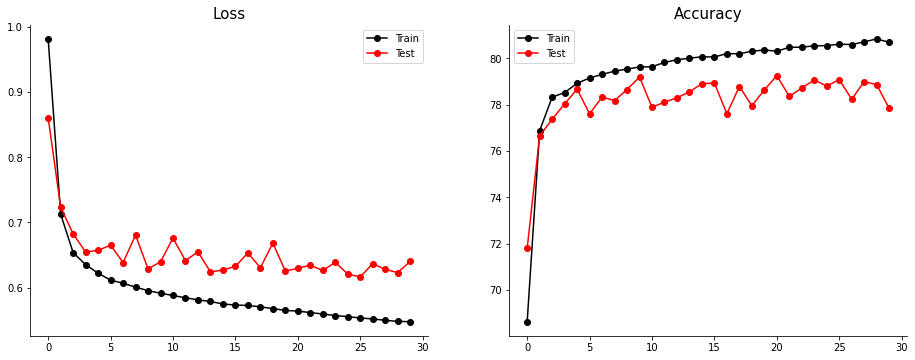

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout(pad=5)

ax[0].plot(losses["train_loss"], "-o", color="k", label="Train")
ax[0].plot(losses["test_loss"], "-o", color="r", label="Test")
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_title("Loss", fontsize=15)
ax[0].legend()


ax[1].plot(losses["train_acc"], "-o", color="k", label="Train")
ax[1].plot(losses["test_acc"], "-o", color="r", label="Test")
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].set_title("Accuracy", fontsize=15)
ax[1].legend()

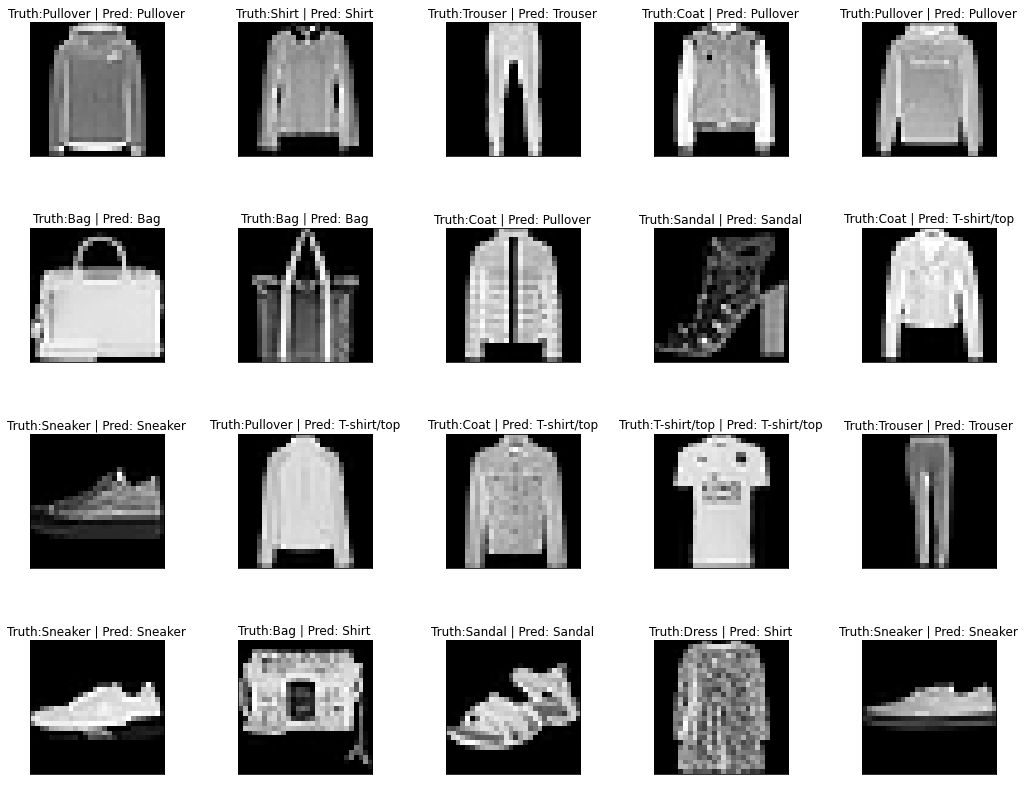

In [9]:
# Plotting the prediction
fig, ax = plt.subplots(4, 5, figsize=(15, 12))
fig.tight_layout(pad=4)
ax = ax.ravel()

model.eval()
with torch.inference_mode():
    input_data, true_label = next(iter(test_dataloader))
    for i in range(20):
        pred_label = DNN_utils.get_model_prediction(model, input_data[i, :, :, :])
        ax[i].imshow(torch.squeeze(input_data[i]), cmap="gray")
        ax[i].set_title(
            "Truth:{} | Pred: {}".format(
                train_data.classes[true_label[i]], train_data.classes[pred_label]
            )
        )
        ax[i].set_xticks([])
        ax[i].set_yticks([])

#### Plot confusion matrix

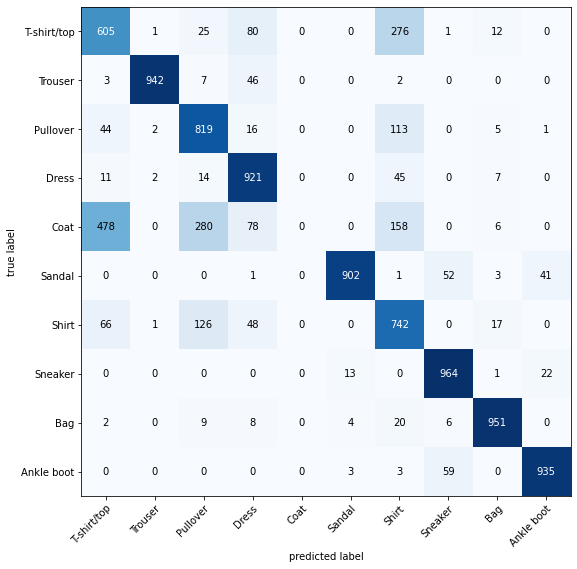

In [12]:
y_truelabels = []
y_predlabels = []

model.eval()
with torch.inference_mode():
    for i, (X, y) in enumerate(test_dataloader):
        y_predlabels.append(model(X.to(device)).argmax(dim=1))
        y_truelabels.append(y)

y_predlabels = torch.cat(y_predlabels)
y_truelabels = torch.cat(y_truelabels)


# Plotting the confusion matrix
confmat = ConfusionMatrix(num_classes=len(train_data.classes))
confmat_tensor = confmat(preds=y_predlabels, target=y_truelabels)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy
    class_names=train_data.classes,  # turn the row and column labels into class names
    figsize=(14, 9),
);

## 4 Building a CNN

### 4.1 Model definition 

In [13]:
class CNN_model(nn.Module):
    # . Mini VGG

    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return self.classifier(x)

## 4.2 Training

In [14]:
INPUT_SHAPE = 1  # nn.Flatten()(next(iter(train_dataloader))[0][0]).shape[1]
HIDDEN_UNITS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = CNN_model(
    input_shape=INPUT_SHAPE,
    hidden_units=HIDDEN_UNITS,  # how many units in the hiden layer
    output_shape=len(train_data.classes),  # one for every class
).to(device)

torch.manual_seed(43)
EPOCHS = 30
train_time_start_on_cpu = timer()

# Loss function and Optimizer
loss_fn = (
    nn.CrossEntropyLoss()
)  # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)
losses = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
for epoch in tqdm(range(EPOCHS)):

    print(f"Epoch: {epoch}\n---------")
    ## TRAINING
    train_results = DNN_utils.train_model(
        model=model1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
    )
    losses["train_loss"].append(train_results["model_loss"])
    losses["train_acc"].append(train_results["model_acc"])

    ## Print out what's happening
    print(
        f"\n Train loss: {train_results['model_loss']:.5f} | Train acc: {train_results['model_acc']:.2f}%\n"
    )

    ## TESTING
    test_results = DNN_utils.test_model(
        model=model1, data_loader=test_dataloader, loss_fn=loss_fn
    )
    losses["test_loss"].append(test_results["model_loss"])
    losses["test_acc"].append(test_results["model_acc"])

    ## Print out what's happening
    print(
        f"Test loss: {test_results['model_loss']:.5f} | Test acc: {test_results['model_acc']:.2f}%\n"
    )


train_time_end_on_cpu = timer()
total_train_time_model_0 = DNN_utils.print_train_time(
    start=train_time_start_on_cpu,
    end=train_time_end_on_cpu,
    device=str(next(model.parameters()).device),
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------

 Train loss: 0.57714 | Train acc: 79.15%

Test loss: 0.41275 | Test acc: 84.98%

Epoch: 1
---------

 Train loss: 0.36496 | Train acc: 86.80%

Test loss: 0.35847 | Test acc: 86.57%

Epoch: 2
---------

 Train loss: 0.32505 | Train acc: 88.31%

Test loss: 0.35208 | Test acc: 87.19%

Epoch: 3
---------

 Train loss: 0.30631 | Train acc: 88.94%

Test loss: 0.31278 | Test acc: 88.88%

Epoch: 4
---------

 Train loss: 0.29224 | Train acc: 89.40%

Test loss: 0.30993 | Test acc: 88.93%

Epoch: 5
---------

 Train loss: 0.27936 | Train acc: 90.04%

Test loss: 0.29013 | Test acc: 89.74%

Epoch: 6
---------

 Train loss: 0.27106 | Train acc: 90.19%

Test loss: 0.30717 | Test acc: 88.88%

Epoch: 7
---------

 Train loss: 0.26318 | Train acc: 90.46%

Test loss: 0.28674 | Test acc: 89.60%

Epoch: 8
---------

 Train loss: 0.25625 | Train acc: 90.70%

Test loss: 0.28555 | Test acc: 89.83%

Epoch: 9
---------

 Train loss: 0.25193 | Train acc: 90.87%

Test loss: 0.27552 | Test acc

### 4.3 Visualizing the model performance

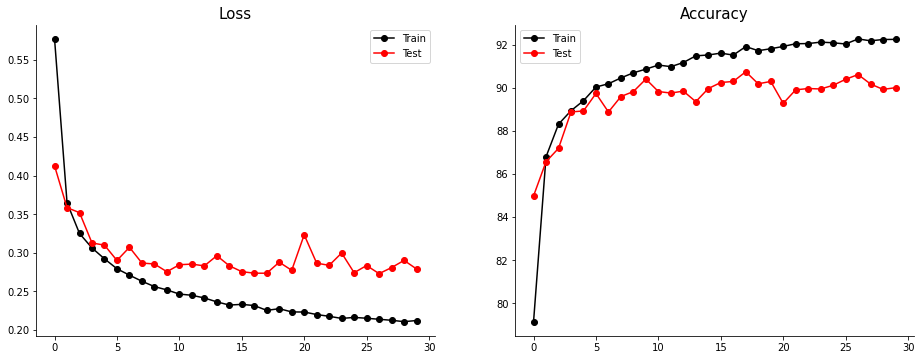

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout(pad=5)

ax[0].plot(losses["train_loss"], "-o", color="k", label="Train")
ax[0].plot(losses["test_loss"], "-o", color="r", label="Test")
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_title("Loss", fontsize=15)
ax[0].legend()


ax[1].plot(losses["train_acc"], "-o", color="k", label="Train")
ax[1].plot(losses["test_acc"], "-o", color="r", label="Test")
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].set_title("Accuracy", fontsize=15)
ax[1].legend()

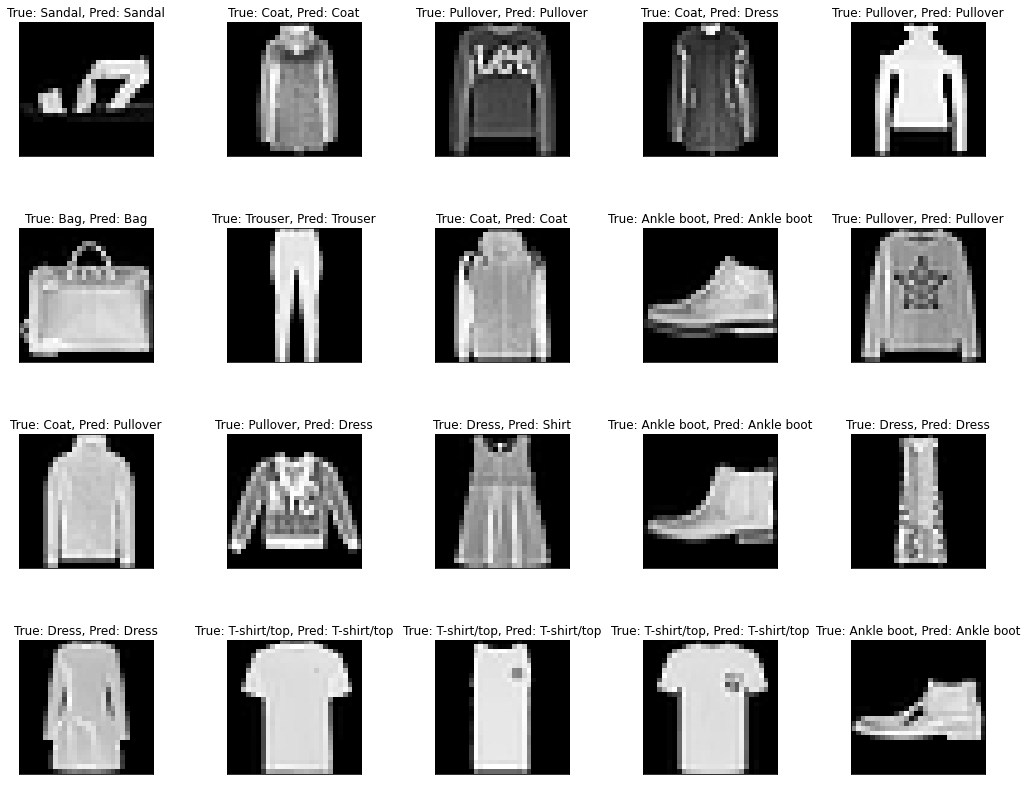

In [16]:
# Plotting the prediction
fig, ax = plt.subplots(4, 5, figsize=(15, 12))
fig.tight_layout(pad=4)
ax = ax.ravel()

input_data, true_labels = next(iter(test_dataloader))
model1.eval()
with torch.inference_mode():
    for i in range(20):
        pred_label = DNN_utils.get_model_prediction(
            model1, input_data[i].view([1, 1, 28, 28])
        )
        ax[i].imshow(torch.squeeze(input_data[i]), cmap="gray")
        ax[i].set_title(
            "True: {}, Pred: {}".format(
                train_data.classes[true_labels[i]], train_data.classes[pred_label]
            )
        )
        ax[i].set_xticks([])
        ax[i].set_yticks([])

#### PLotting the confusion matrix

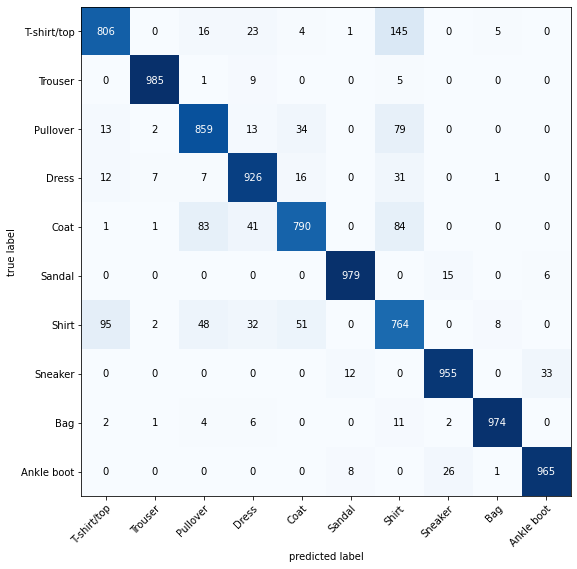

In [20]:
y_truelabels = []
y_predlabels = []

model1.eval()
with torch.inference_mode():
    for i, (X, y) in enumerate(test_dataloader):
        y_predlabels.append(model1(X.to(device)).argmax(dim=1))
        y_truelabels.append(y)

y_predlabels = torch.cat(y_predlabels)
y_truelabels = torch.cat(y_truelabels)


# Plotting the confusion matrix
confmat = ConfusionMatrix(num_classes=len(train_data.classes))
confmat_tensor = confmat(preds=y_predlabels, target=y_truelabels)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy
    class_names=train_data.classes,  # turn the row and column labels into class names
    figsize=(14, 9),
);